# mI MRS_Voxel-to-Voxel

## Make a mask
===============

The Seed-to-Voxel connectivities from healthy controls are averaged and thresholded to 0.3 (corresponding to approximately p = 0.01), giving the ROI

## Extract connectivities
=========================

After applyng the mask to every connectivity mask (CONN's files with BETA prefix), the connectivities of every grey matter voxel are summed giving the connectivity value for the individual subject.

Ref: ToDo


Prefixes:
=========
-) BETA_ nii the BETA files contain the Fisher transformed coefficients ( z=atanh(r) ). When the Analyses.measure is set to 3 (regression) or 4 (multivariate regression), then the BETA files contain the regression coefficients (beta values) and the corr files should be disregarded (they actually contain tanh(beta) but these are not particularly meaningful measures). 

-) corr_ nii When the Analyses.measure field is set to 1 (bivariate correlation) or 2 (semi-partial correlation) the corr fles contain the correlation coefficients (r) (or semi-partial correlation coefficients when Analyses.measure is set to 2)..... corr_* files are only generated if you select the corresponding option in the Setup->Options tab ('Create first-level seed-to-voxel r-maps').

-) p_corr nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) pFDR nii the p_corr and pFDR images simply contain the uncorrected and FDR-corrected p-values, respectively

-) resultsROI mat

-) se nii
-) 

## Sources

In [1]:
import glob
import nibabel as nib
import pandas as pd
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn import image
import numpy as np
from scipy.io import loadmat
from scipy import stats
import os

In [2]:
# Load Subjects' data
cov_path = '/media/2Tb/functional_analysis_jan2021/conn_covs.csv'
data = pd.read_csv(cov_path)

In [3]:
mat = loadmat('/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/_list_sources.mat')

In [4]:
mat['sourcenames']

array([[array(['MRS_Voxel'], dtype='<U9'),
        array(['MRS_Voxel_MNI2009'], dtype='<U17')]], dtype=object)

In [5]:
# Grab all MRS-Voxel-to-whole-Brain connectivity maps niftis
#s1_beta_path = glob.glob('/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/BETA_Subject*_Condition001_Source002.nii')
beta_paths_mask = '/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/BETA_Subject{num}_Condition001_Source002.nii'
beta_paths = [beta_paths_mask.format(num=str(i).zfill(3)) for i in data.CONN_ID]

In [6]:
subnumber = len(beta_paths)

In [7]:
# Grab all MNI registered GM masks
gm_masks_mask = '/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/data/BIDS/dataset/sub-{num}/roi/esub-{num}_roi-GreyMatter.nii'

In [8]:
gm_masks = [gm_masks_mask.format(num=str(i).zfill(4)) for i in data.CONN_sub_ID]

In [9]:
data['BETA_paths'] = beta_paths

In [10]:
data['gm_masks'] = gm_masks

In [11]:
data['index'] = data.index

In [12]:
hc_pos = data[(data.diag == 0)]['index'].values

In [13]:
len(hc_pos)

25

In [14]:
%%time
# Summing the HC connectivity masks
avg_mask = nib.load(data.BETA_paths[list(hc_pos)[0]]).get_fdata()

for subnum in list(hc_pos)[1:]: 
    conn_map = nib.load(data.BETA_paths[subnum]).get_fdata() # Load connectivities as numpy array
    avg_mask += conn_map

CPU times: user 817 ms, sys: 1.39 s, total: 2.2 s
Wall time: 6.43 s


In [15]:
avg_mask.shape

(193, 229, 193)

In [16]:
# average
avg_mask = avg_mask / len(hc_pos)

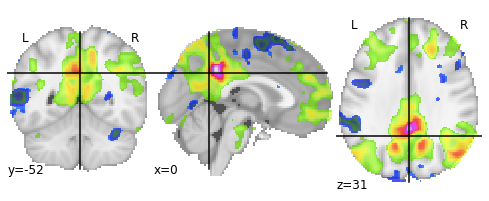

In [17]:
plotting.plot_roi(nib.load(data.BETA_paths[list(hc_pos)[5]]), threshold=0.30)

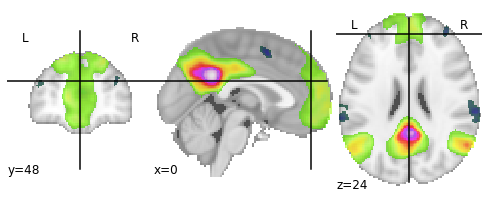

In [18]:
example_img = nib.load(data.BETA_paths[list(hc_pos)[0]])
mask_nii = nib.Nifti1Image(avg_mask, example_img.affine, header=example_img.header)
plotting.plot_roi(mask_nii, threshold=0.3)

In [19]:
# thresholding
threshold = 0.30 # corresponding p<0.01 for our sample size
avg_mask = np.where(avg_mask>threshold,1,0)

In [20]:
# Making nii
example_img = nib.load(data.BETA_paths[list(hc_pos)[0]])
mask_nii = nib.Nifti1Image(avg_mask, example_img.affine, header=example_img.header)

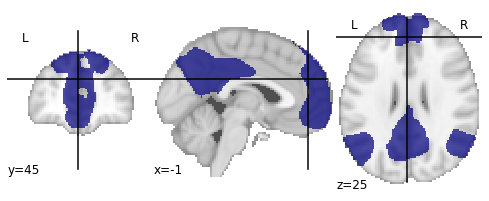

In [21]:
plotting.plot_roi(mask_nii)

In [22]:
# Save mask as NifTi
nib.save(mask_nii, '../mIns_avg_Mask_PCC_thres_03_HC.nii.gz')

In [23]:
%%time
mean_conn = list()
sum_conn = list()
for num in data.CONN_sub_ID.values:
    beta = data[(data.CONN_sub_ID == num)].BETA_paths.values[0]
    gm = data[(data.CONN_sub_ID == num)].gm_masks.values[0]
    if not os.path.isfile(gm): # CONN generated for 2 subjects no binary mask in ROI, but we can use c1sub-0042_run-01_T1w in anat instead
        print(gm)
        gm = '/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/data/BIDS/dataset/sub-{num}/anat/c1sub-{num}_run-01_T1w.nii'.format(num=str(num).zfill(4))
    gm = nib.load(gm).get_fdata() #load GM mask
    img = nib.load(beta).get_fdata() # load Connectivity map
    hc_mask_gm = np.where(gm,avg_mask,0) # mask the HC mask with subject's GM mask
    mask_voxels = hc_mask_gm.sum() # number of GM voxels in the mask
    masked_img = np.where(hc_mask_gm,img,0) # mask with 
    mean_conn.append(masked_img.sum()/mask_voxels)
    sum_conn.append(masked_img.sum())

CPU times: user 7.95 s, sys: 10.3 s, total: 18.3 s
Wall time: 50 s


In [24]:
data['mean_conn'] = mean_conn
data['sum_conn'] = sum_conn

<AxesSubplot:>

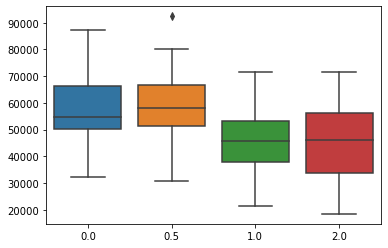

In [25]:
sns.boxplot(y=data.sum_conn.values, x=data.diag.values)

<AxesSubplot:>

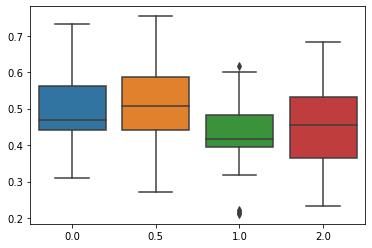

In [26]:
sns.boxplot(y=data.mean_conn.values, x=data.diag.values)

<AxesSubplot:>

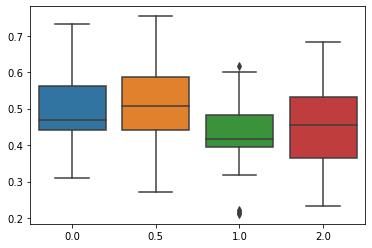

In [92]:
sns.boxplot(y=data.mean_conn.values, x=data.diag.values)

<AxesSubplot:>

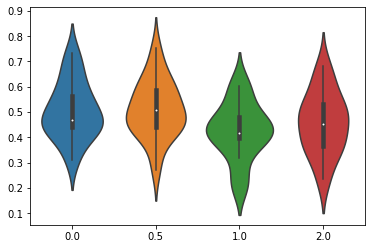

In [96]:
sns.violinplot(y=data.mean_conn.values, x=data.diag.values)

In [88]:
from scipy import stats

In [97]:
stats.f_oneway(data[(data.diag==0)].mean_conn,
              data[(data.diag==0.5)].mean_conn,
               data[(data.diag==1)].mean_conn,
              data[(data.diag==2)].mean_conn)

F_onewayResult(statistic=3.0415571554476717, pvalue=0.0330328504888458)

In [101]:
stats.f_oneway(data[(data.diag==0.5)].mean_conn,
              data[(data.diag==2)].mean_conn)

F_onewayResult(statistic=2.2994261427990597, pvalue=0.1369129748378043)

In [ ]:
masked_img_nii = nib.Nifti1Image(masked_img, example_img.affine, header=example_img.header)

In [ ]:
plotting.plot_roi(masked_img_nii)

In [29]:
os.getcwd()

'/media/10Tb/functional_analysis_jan2021/mIns_fMRI/notebooks'

In [31]:
data.to_csv('./conns_202106.csv')